In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [77]:
import wispy.lalutils
import wispy.model_utils
import wispy.callbacks

In [4]:
import lalsimulation as lalsim

# try using the code from other notebook

In [5]:
def gen_data(n_cases):

    s1s = np.linspace(0., 0.99, n_cases)[:,np.newaxis]
    ps = [wispy.lalutils.gen_td_wf_params(m1=100., S1x=s1[0], approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6) for s1 in s1s]
    
    times = []
    amp = []
    phase = []

    for p in ps:
        _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
        times.append(_times)
        amp.append(_amp)
        phase.append(_phase)
        
    # find common times and interpolate data onto common time grid
    dt_M = 0.5
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    print(f"common_tmin = {common_tmin}")
    print(f"common_tmax = {common_tmax}")

    common_times = np.arange(common_tmin, common_tmax, dt_M)

    ntimes = len(common_times)
    print(f"ntimes = {ntimes}")

    amps = np.zeros(shape=(n_cases, ntimes))
    phases = np.zeros(shape=(n_cases, ntimes))

    for i in range(n_cases):
        amps[i] = IUS(times[i], amp[i])(common_times)
        phases[i] = IUS(times[i], phase[i])(common_times)
        
        
    return common_times, amps, phases, s1s

In [67]:
n_cases = 20
common_times, amps, phases, x = gen_data(n_cases)

common_tmin = -499.68236376260626
common_tmax = 39.67834692080017
ntimes = 1079


In [68]:
common_times.shape

(1079,)

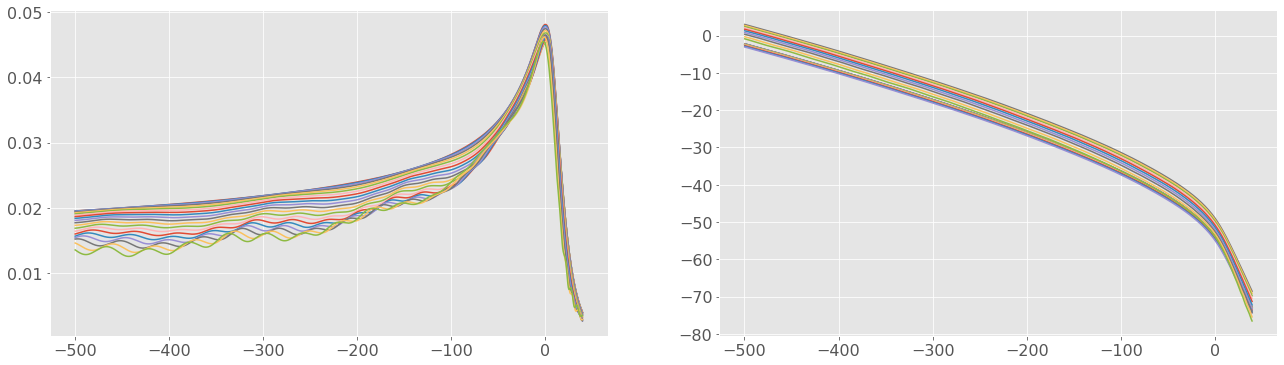

In [78]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for y in amps:
    plt.plot(common_times, y)
    
# plt.xlim(-100, 40)


plt.subplot(1, 2, 2)
for y in phases:
    plt.plot(common_times, y)

In [ ]:
# as an alternative to this lets try and subtract a fiducial waveform, maybe the average waveform -
# then model the residual waveform - this I think would regularise the data around the peak amplitude
# which has been difficult to capture in the past.

In [230]:
amp_max = amps.max()
y = amps/amp_max
ymean = np.mean(y, axis=0)[np.newaxis, :]
y -= ymean


# y = phases
# y = np.array([yy-yy[0] for yy in y])
# ymean = np.mean(y, axis=0)[np.newaxis, :]
# y -= ymean
# y_max = y.max()
# y = y/y_max

# y = phases

# x = np.array([m1s[0], m1s[1], m1s[3], m1s[4]])
# xval = np.array([m1s[2]])

# y = np.array([_y[0], _y[1], _y[3], _y[4]])
# yval = np.array([_y[2]])

In [231]:
y.shape

(20, 1079)

In [232]:
ymean.shape

(1, 1079)

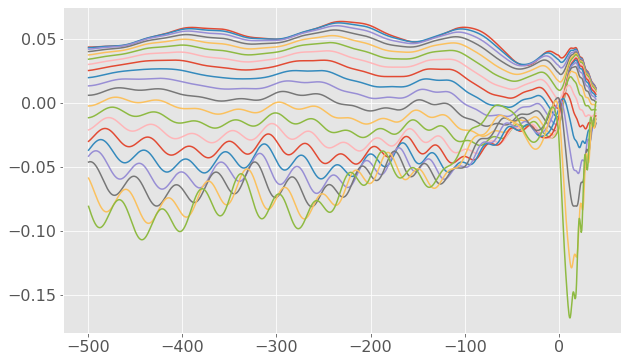

In [235]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for yy in y:
    plt.plot(common_times, yy)
    
# plt.xlim(-100, 40)

In [187]:
def build_decoder(input_shape, output_shape, units, acts, skip=False):
    # build the decoder
    input_layer = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(input_layer)
        else:
            x = layers.Dense(unit, activation=act)(x)
            
    if skip:
        x = layers.Dense(input_shape, activation='linear')(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
            
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(input_layer, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model

In [188]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
        # boundaries = [500, 600]
        # values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)
    
    threshold_callback = wispy.callbacks.ThresholdCallback(1e-9)
    callbacks.append(threshold_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    if validation_data:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_mse'], label='val_mse')

        plt.yscale('log')
        plt.legend()
    
    return history, model

In [236]:
# model = build_decoder(input_shape=x.shape[1], output_shape=y.shape[1], units = [16, 128, 512, 512], acts = ['relu', 'relu', 'relu', 'relu'])
model = build_decoder(input_shape=x.shape[1], output_shape=y.shape[1], units = [64, 1000], acts = ['relu', 'relu'])

In [237]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_54 (Dense)             (None, 1000)              65000     
_________________________________________________________________
dense_55 (Dense)             (None, 1079)              1080079   
Total params: 1,145,207
Trainable params: 1,145,207
Non-trainable params: 0
_________________________________________________________________


Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 2min 3s, sys: 7.89 s, total: 2min 11s
Wall time: 38.9 s


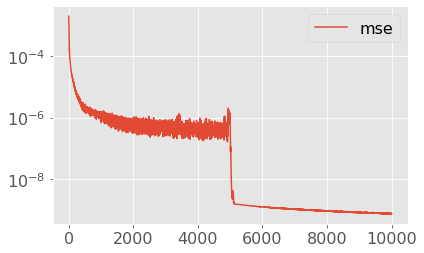

In [238]:
%%time
amp_history, model_amp = initial_fit(
    model,
    x=x,
    y=y,
    validation_data=None,
    epochs=10000,
    batch_size=20,
    validation_freq=1000,
    lr=None)

In [239]:
amp_history.history['mse'][-1]

7.564562309880785e-10

In [240]:
def compare_models(model, x, y, index, times=common_times):
    
    yhat = model.predict(x)[index]
    yhat += ymean[0]
    
    y = y[index]
    y += ymean[0]
    
    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat', ls='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-200, 20)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"(approx,q)={np.around(x[index], 3)}"
    plt.suptitle(title)

In [241]:
x.shape

(20, 1)

In [242]:
y.shape

(20, 1079)

In [243]:
common_times.shape

(1079,)

In [244]:
x

array([[0.        ],
       [0.05210526],
       [0.10421053],
       [0.15631579],
       [0.20842105],
       [0.26052632],
       [0.31263158],
       [0.36473684],
       [0.41684211],
       [0.46894737],
       [0.52105263],
       [0.57315789],
       [0.62526316],
       [0.67736842],
       [0.72947368],
       [0.78157895],
       [0.83368421],
       [0.88578947],
       [0.93789474],
       [0.99      ]])

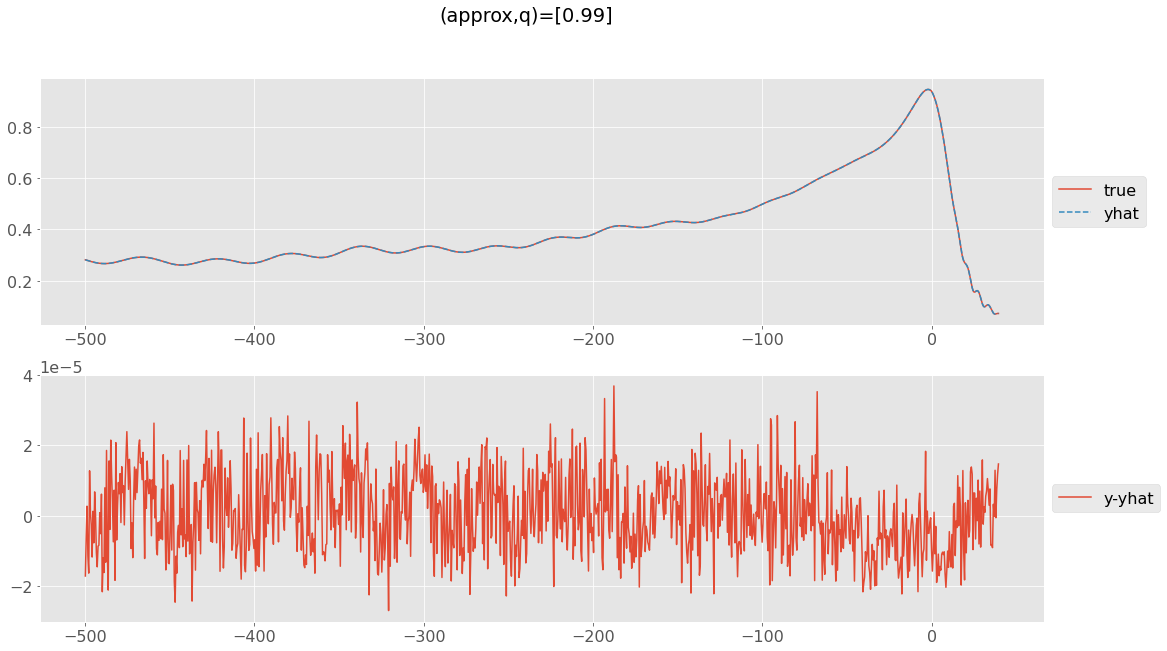

In [245]:
compare_models(model_amp, x, y, -1, common_times)

In [247]:
# n_cases = 30
# common_times_val, amps_val, phases_val, x_val = gen_data(n_cases)

y_val = amps_val/amp_max

y_val -= ymean


In [248]:
x

array([[0.        ],
       [0.05210526],
       [0.10421053],
       [0.15631579],
       [0.20842105],
       [0.26052632],
       [0.31263158],
       [0.36473684],
       [0.41684211],
       [0.46894737],
       [0.52105263],
       [0.57315789],
       [0.62526316],
       [0.67736842],
       [0.72947368],
       [0.78157895],
       [0.83368421],
       [0.88578947],
       [0.93789474],
       [0.99      ]])

In [249]:
x_val

array([[0.        ],
       [0.03413793],
       [0.06827586],
       [0.10241379],
       [0.13655172],
       [0.17068966],
       [0.20482759],
       [0.23896552],
       [0.27310345],
       [0.30724138],
       [0.34137931],
       [0.37551724],
       [0.40965517],
       [0.4437931 ],
       [0.47793103],
       [0.51206897],
       [0.5462069 ],
       [0.58034483],
       [0.61448276],
       [0.64862069],
       [0.68275862],
       [0.71689655],
       [0.75103448],
       [0.78517241],
       [0.81931034],
       [0.85344828],
       [0.88758621],
       [0.92172414],
       [0.95586207],
       [0.99      ]])

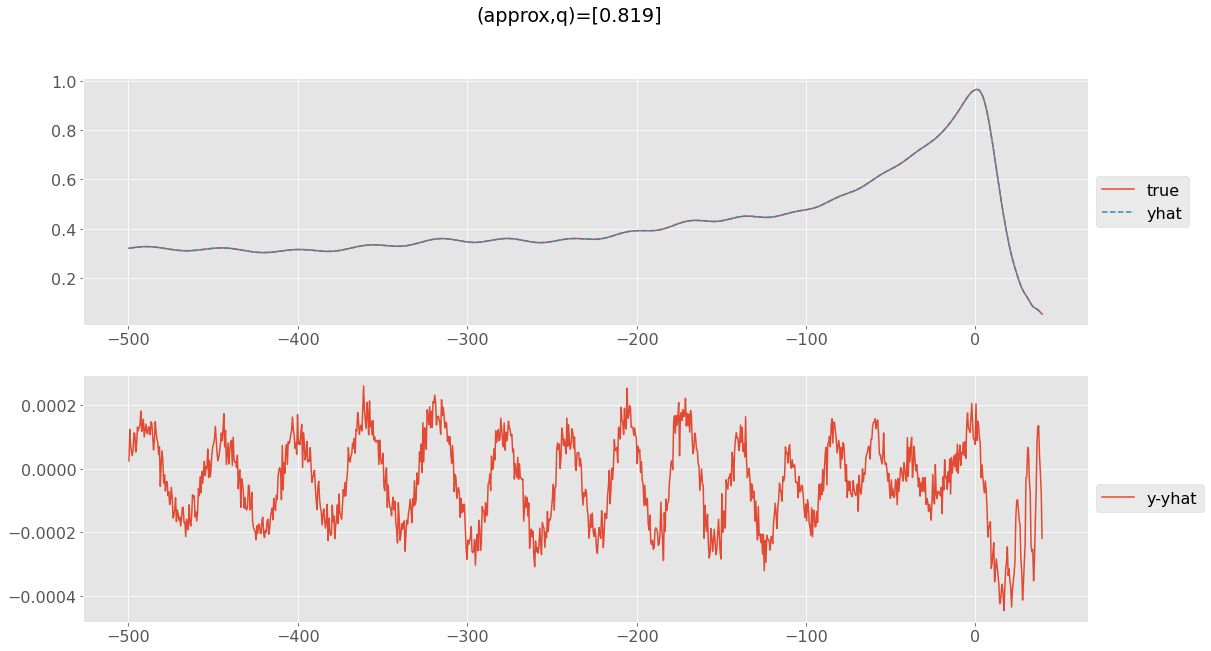

In [256]:
compare_models(model_amp, x_val, y_val, -6, common_times_val)